### Preprocess SOC Sweep Data

In [2]:
import sys
from pathlib import Path

# Add repo root to Python path for imports
repo_root = Path.cwd()
while repo_root.name != "Coulombic-Efficiency-Driven-Optimization-of-Health-Aware-Charging-Protocols":
    if repo_root.parent == repo_root:
        raise RuntimeError("Repo root not found. Open the notebook inside the repo.")
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root))

from utils.soc_sweep_preprocess import find_repo_root, process_soc_sweep_for_soh_levels


In [ ]:
repo_root = find_repo_root()
data_root = repo_root / "data"

raw_root  = data_root / "SOC_Sweep_Data"
save_root = data_root / "SOC_Sweep_Data (Processed)"

process_soc_sweep_for_soh_levels(
    raw_root=raw_root,
    save_root=save_root,
    sohs=(70, 80, 90, 100),
    overwrite_existing=False,
)


File exists for Channel 2, Cell 1. Skipping...
File exists for Channel 2, Cell 2. Skipping...
File exists for Channel 2, Cell 3. Skipping...
File exists for Channel 2, Cell 4. Skipping...
File exists for Channel 2, Cell 6. Skipping...
File exists for Channel 3, Cell 5. Skipping...
File exists for Channel 3, Cell 8. Skipping...
File exists for Channel 4, Cell 3. Skipping...
File exists for Channel 4, Cell 7. Skipping...
File exists for Channel 5, Cell 8. Skipping...
File exists for Channel 1, Cell 5. Skipping...
File exists for Channel 1, Cell 6. Skipping...
File exists for Channel 1, Cell 7. Skipping...
File exists for Channel 1, Cell 8. Skipping...
File exists for Channel 2, Cell 6. Skipping...
File exists for Channel 2, Cell 7. Skipping...
File exists for Channel 3, Cell 3. Skipping...
File exists for Channel 3, Cell 4. Skipping...
File exists for Channel 3, Cell 6. Skipping...
File exists for Channel 3, Cell 7. Skipping...
File exists for Channel 1, Cell 1. Skipping...
File exists f

### Plotting the SOC-Sweep Data

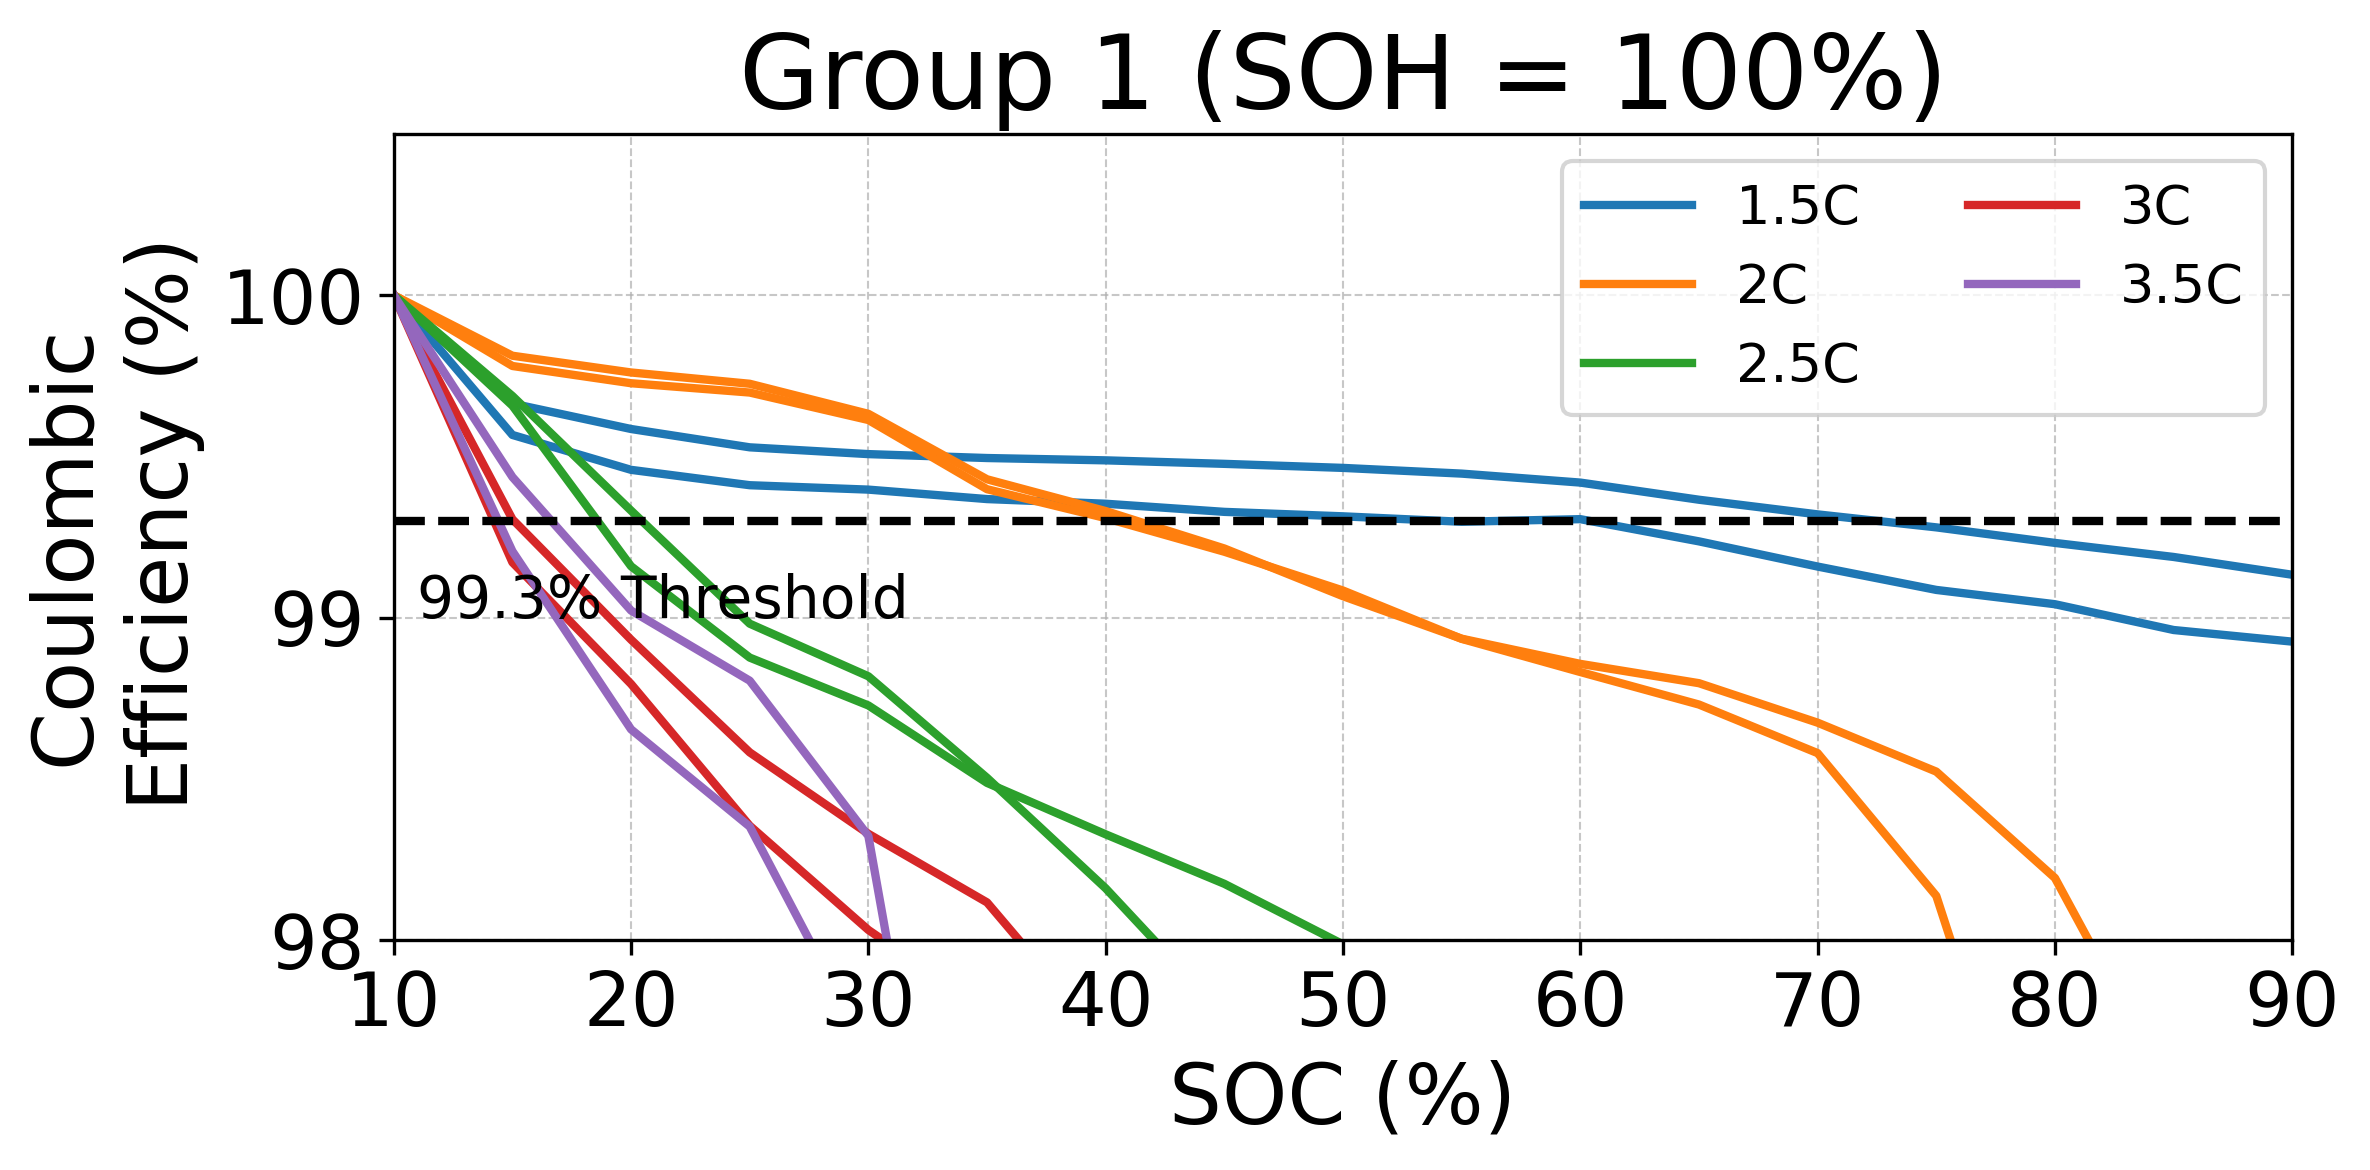

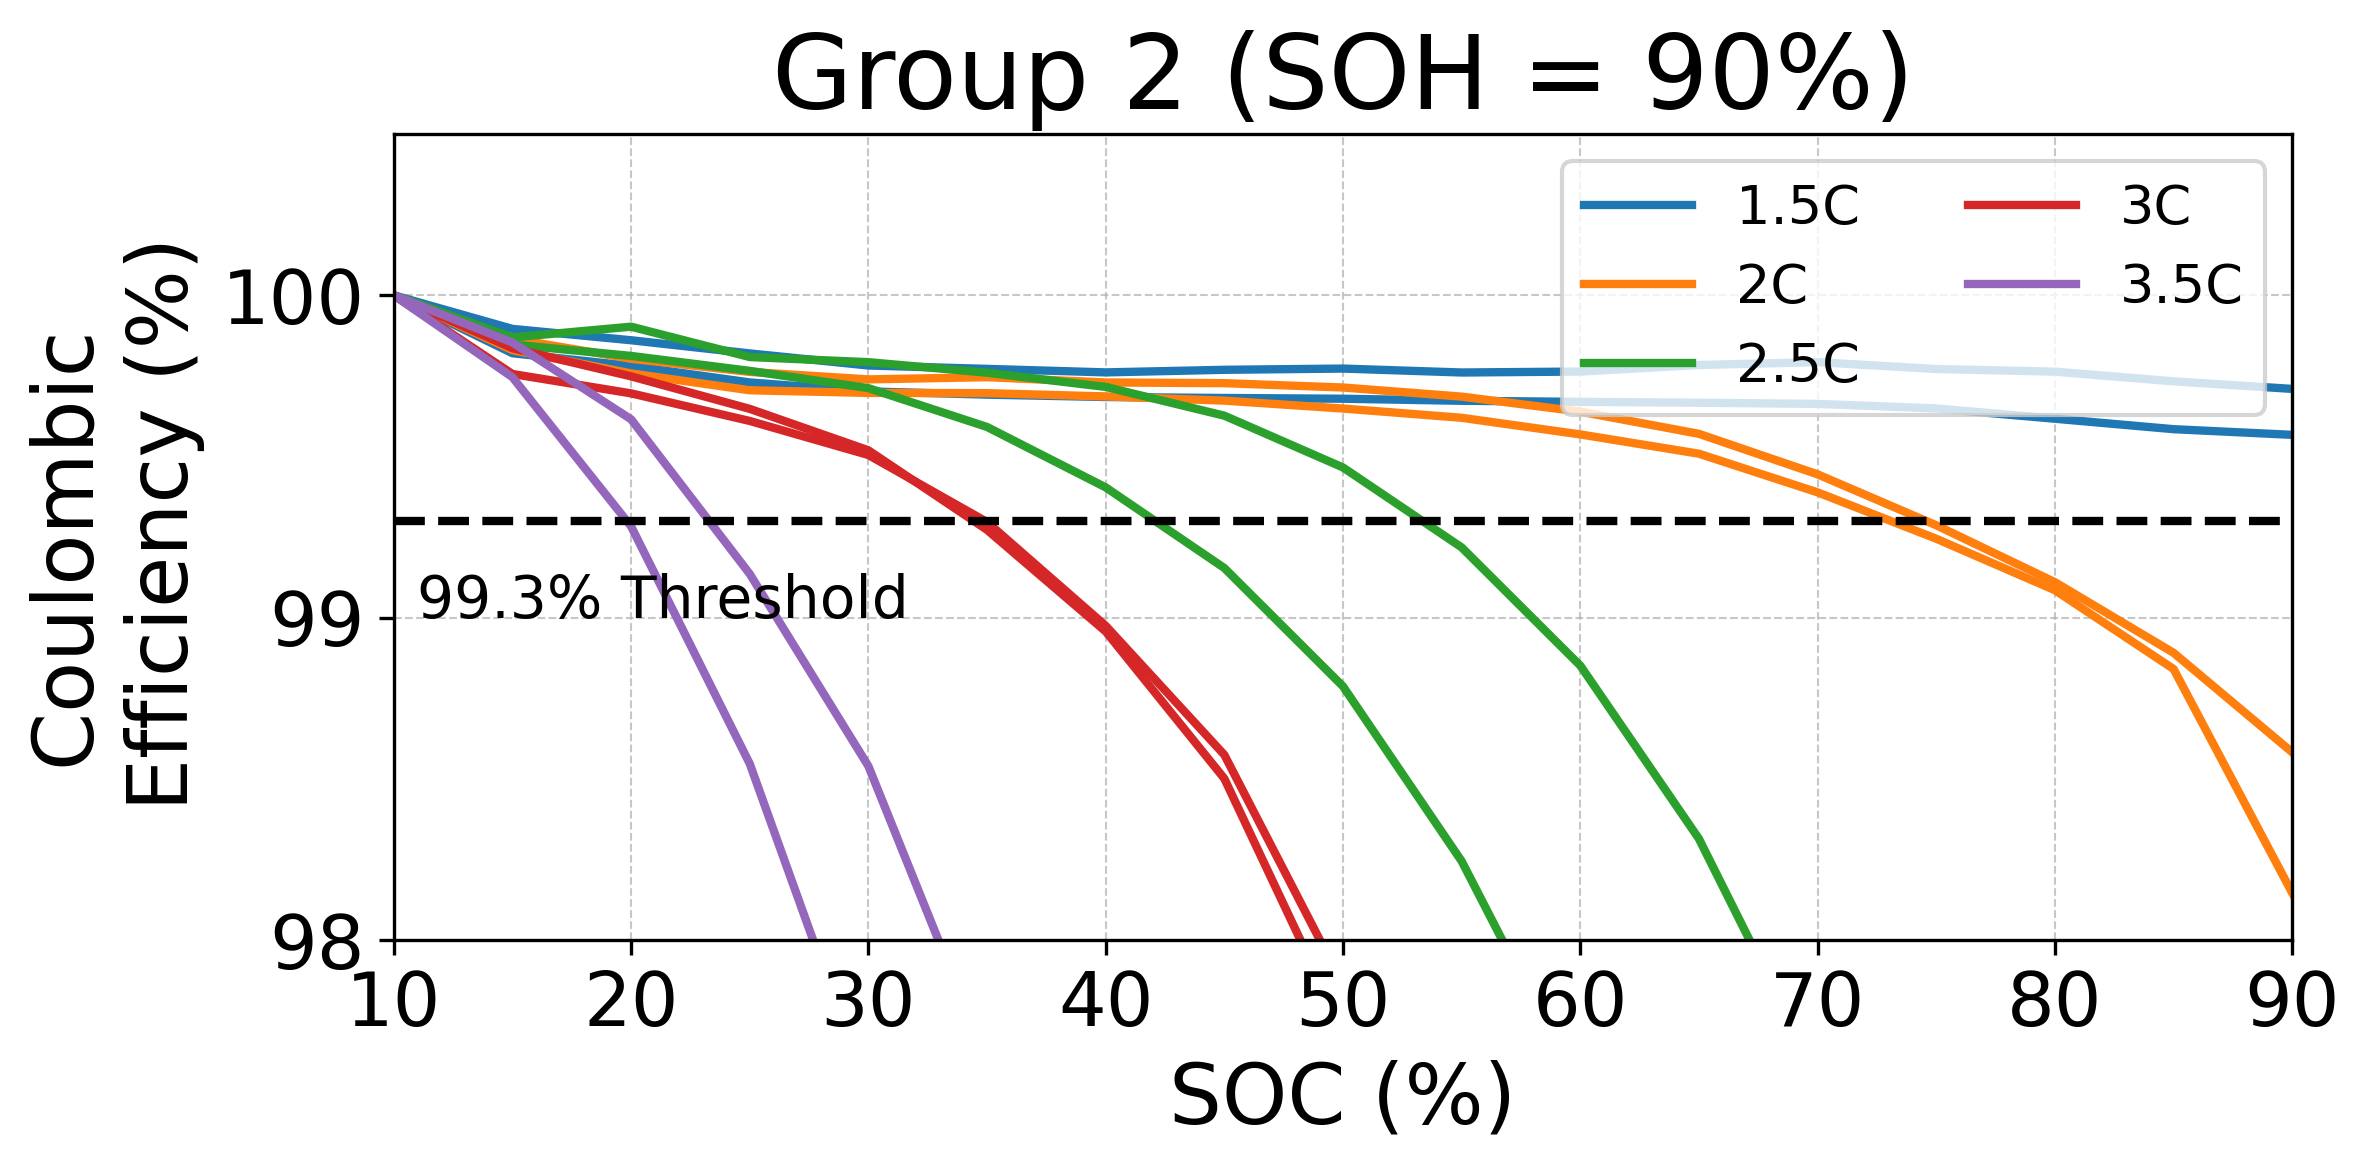

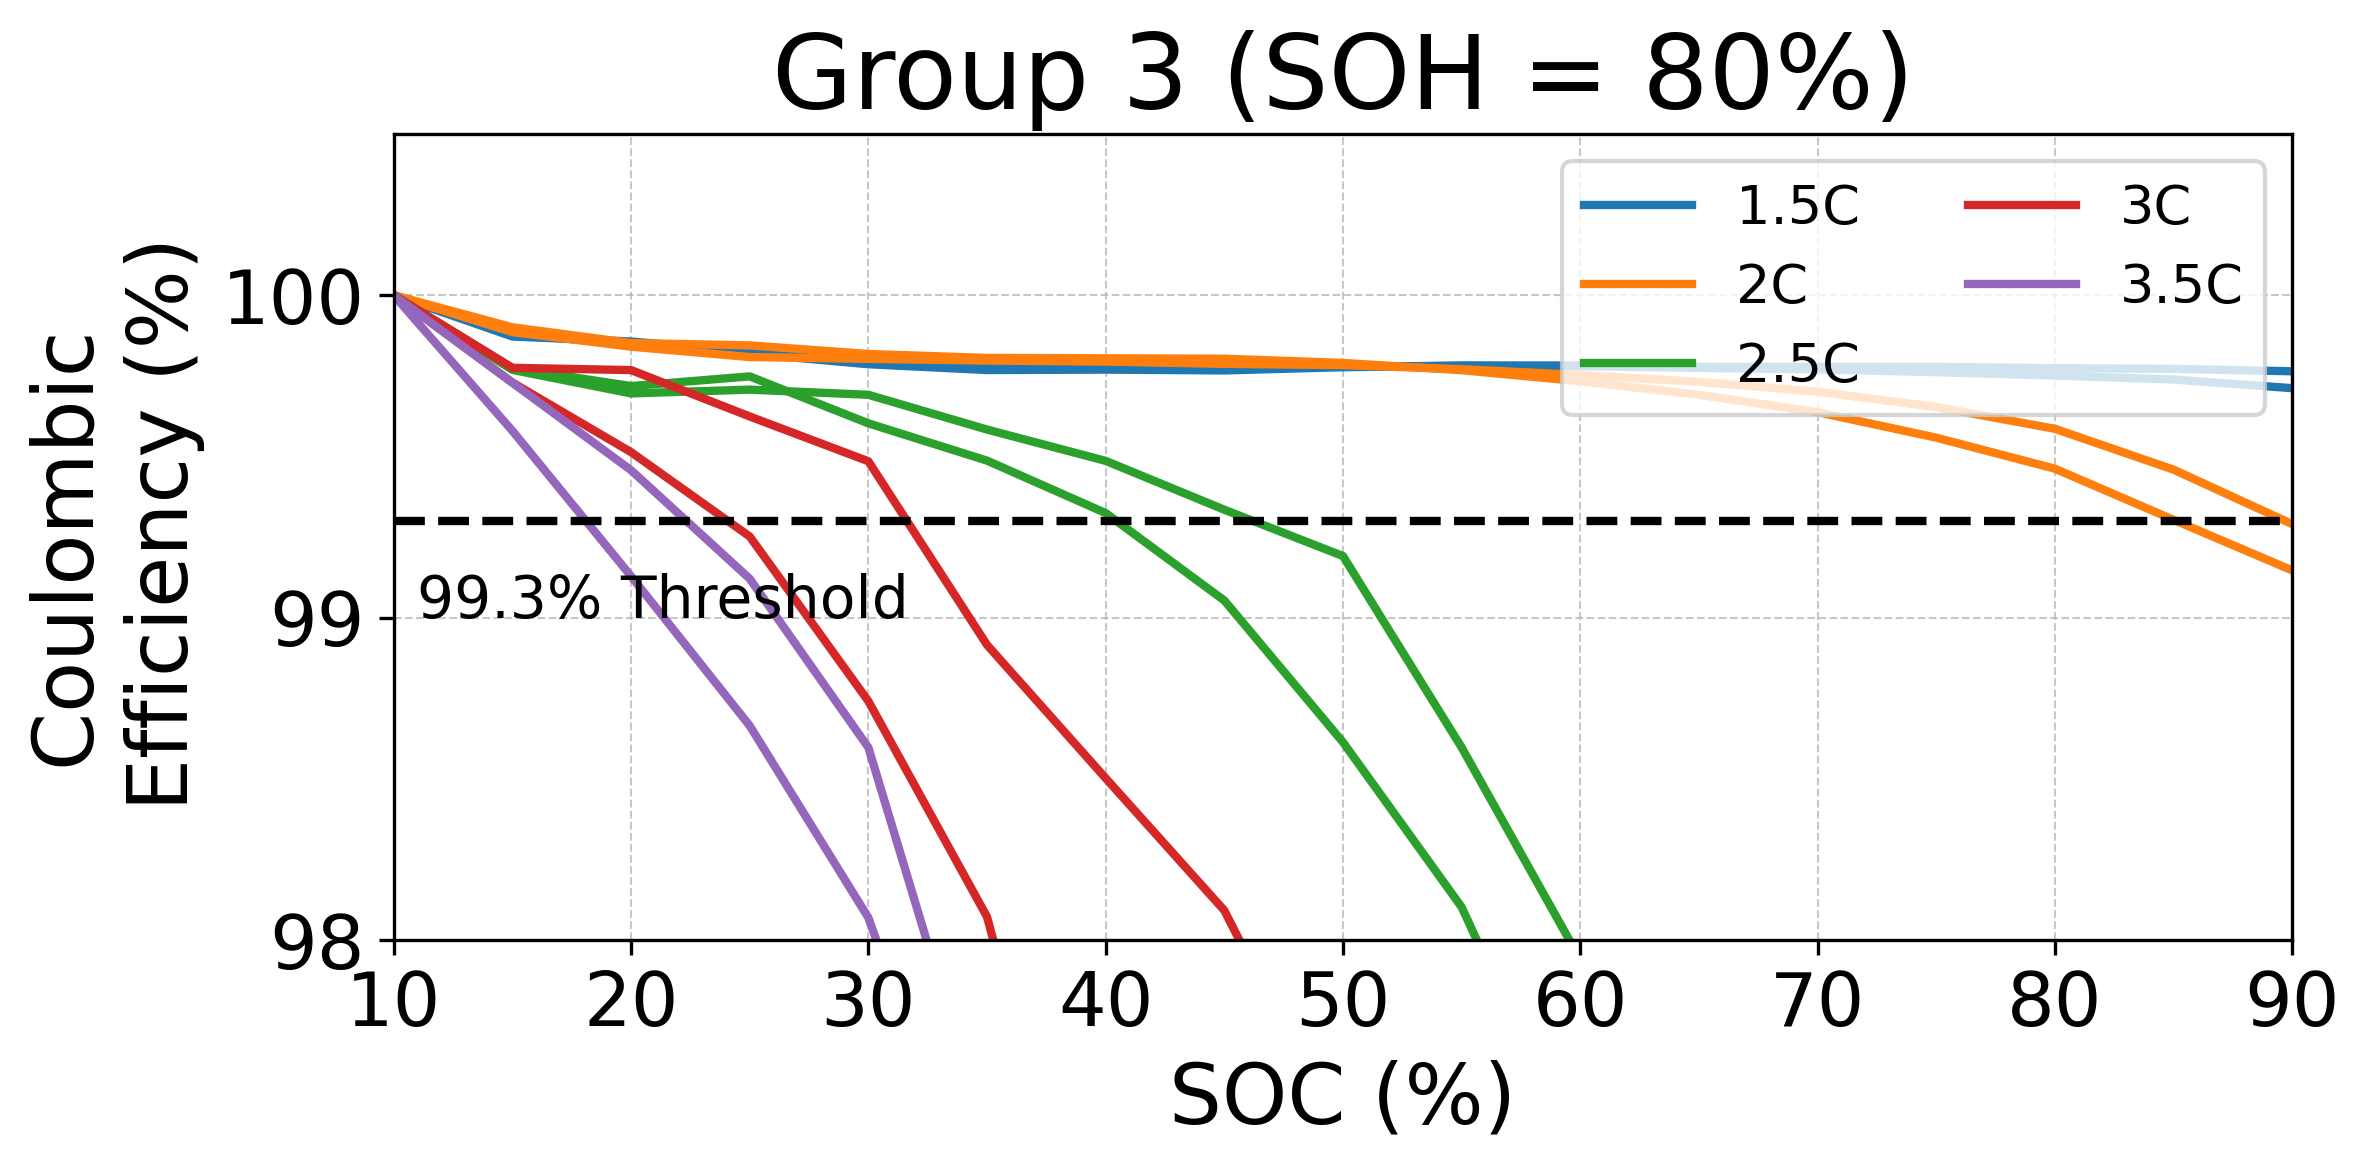

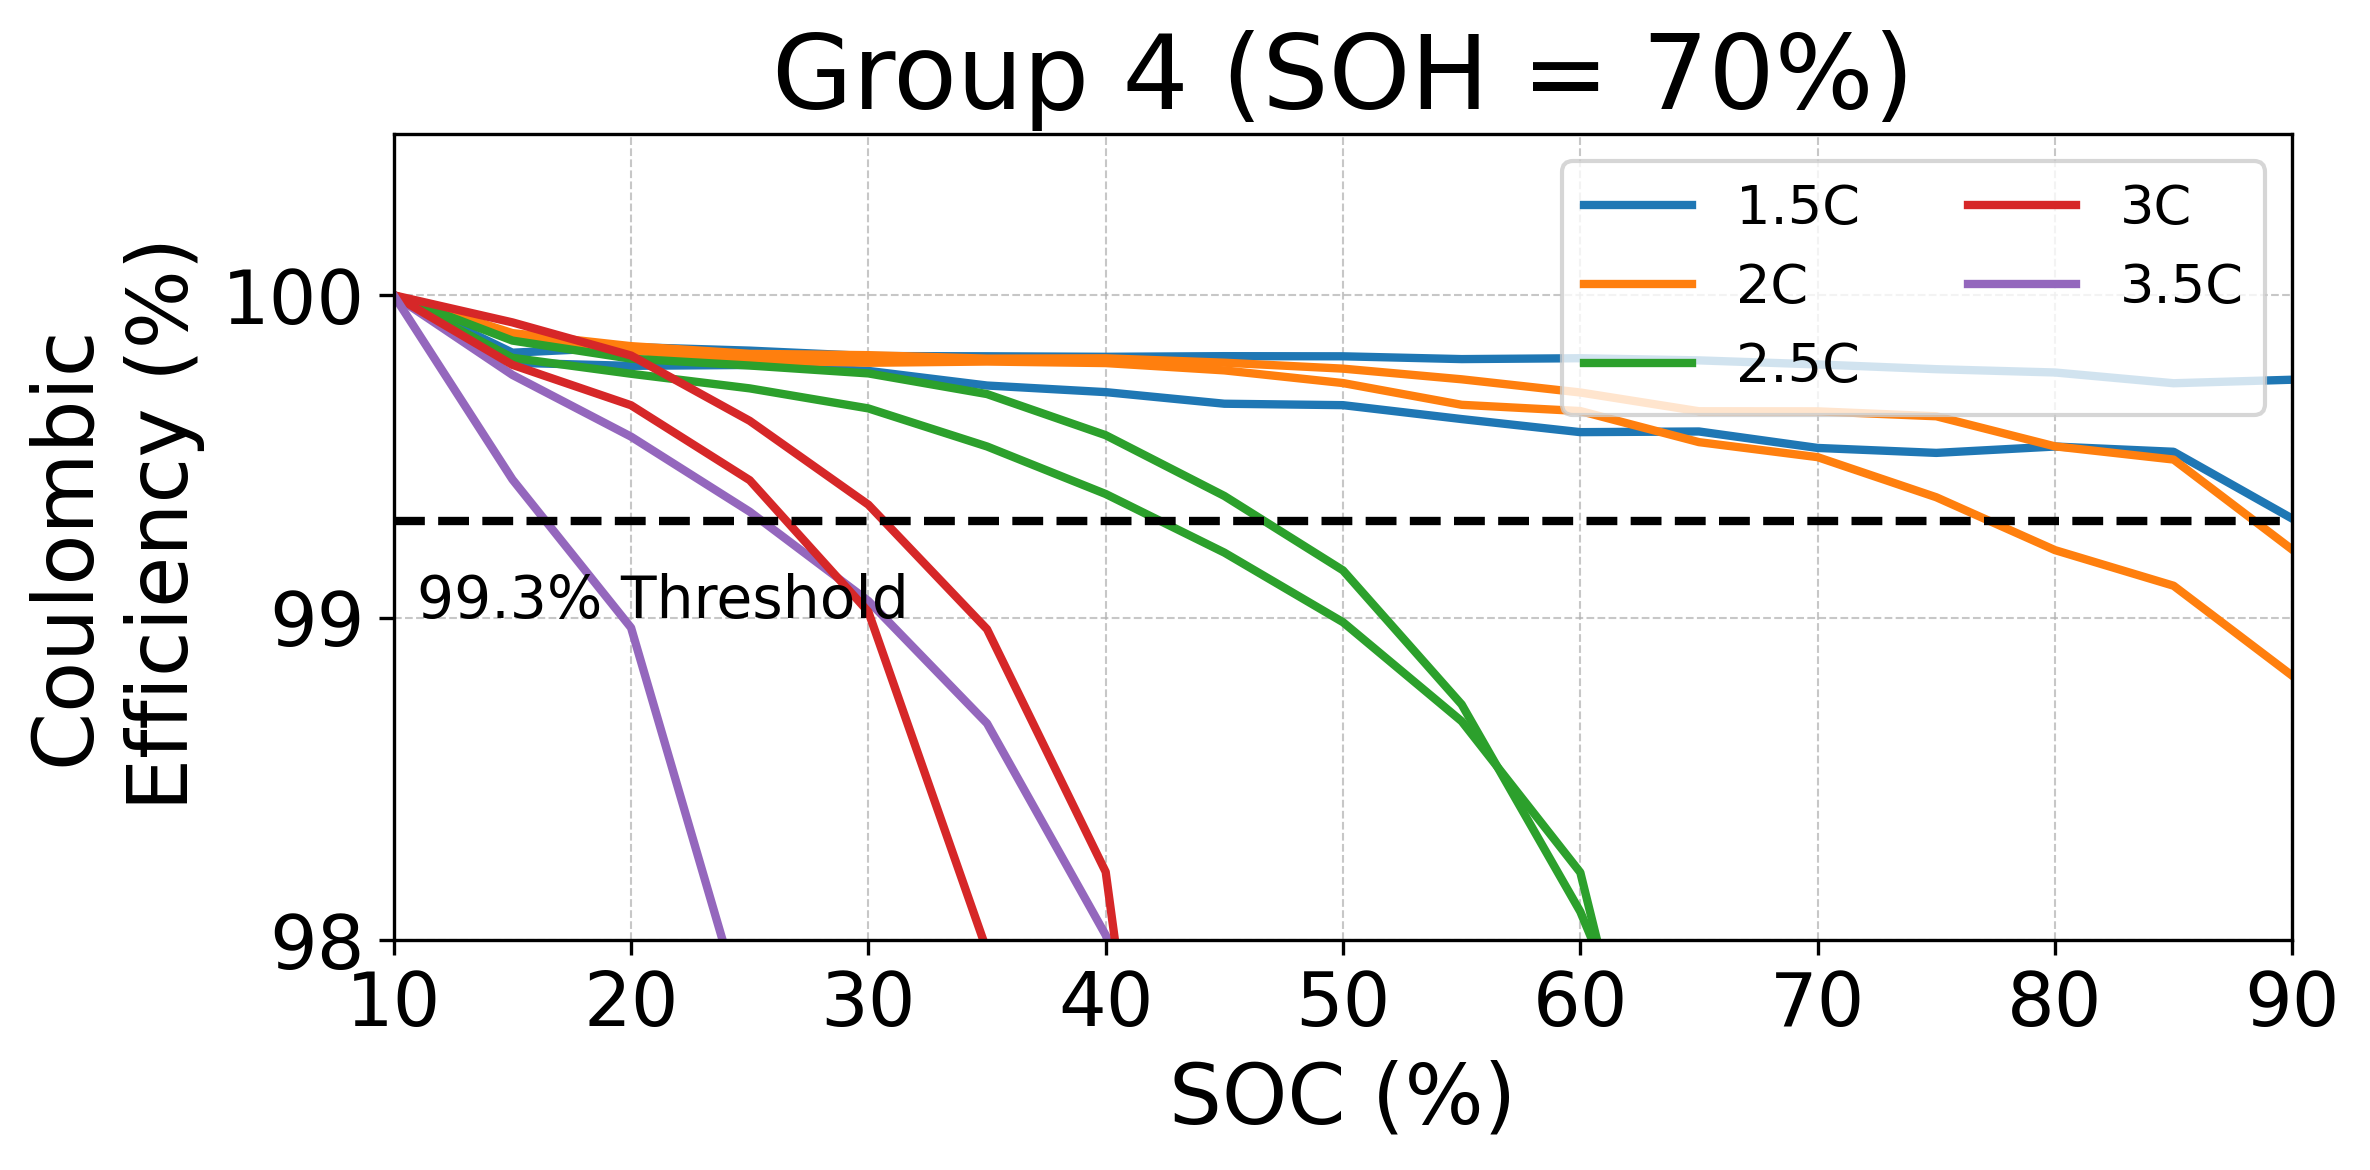

In [ ]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

repo_root = Path.cwd()
while repo_root.name != "Coulombic-Efficiency-Driven-Optimization-of-Health-Aware-Charging-Protocols":
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))

from utils.soc_sweep_analysis import (
    get_default_groups,
    get_coulombic_efficiency,
    shift_ce_to_100,
)

processed_root = repo_root / "data" / "SOC_Sweep_Data (Processed)"
unique_colors = ["C0", "C1", "C2", "C3", "C4"]

for grp in get_default_groups():
    legend_labels = grp["legend_labels"]              # maps legend-key -> "2C"
    channels_cells = grp["channels_cells"]            # {channel: [cells]}
    cell_to_legend_label = grp["cell_to_legend_label"]# (channel,cell)-> legend-key
    title = grp["title"]
    soh = grp["SOH"]

    color_map = {k: unique_colors[i] for i, k in enumerate(legend_labels.keys())}
    plotted = set()

    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

    for channel_id, cells in channels_cells.items():
        for cell_id in cells:
            key = cell_to_legend_label.get((channel_id, cell_id))
            if key is None:
                continue

            # faithful to your pipeline: dir_processed points to SOH folder
            dir_processed = processed_root / f"SOH{soh}"
            ret = get_coulombic_efficiency(
                dir_processed=dir_processed,
                channel_id=int(channel_id),
                cell_id=int(cell_id),
                soc=None,
            )

            ce = ret["CE"] * 100
            u_ce = ret["u_CE"] * 100
            ce, u_ce = shift_ce_to_100(ce, u_ce)

            ax.plot(
                ret["SOC"],
                ce,
                "-",
                color=color_map.get(key, "C0"),
                linewidth=2,
                label=(key if key not in plotted else None),
            )
            plotted.add(key)

    # ordered legend + relabel to C-rate values
    handles, labels = ax.get_legend_handles_labels()
    sel_h, sel_l = [], []
    for k in legend_labels.keys():
        for h, l in zip(handles, labels):
            if l == k:
                sel_h.append(h)
                sel_l.append(legend_labels[k])
                break
    ax.legend(sel_h, sel_l, ncol=2, loc="upper right", fontsize=13, frameon=True)

    ax.plot([10, 90], [99.3, 99.3], "k--", linewidth=2)
    ax.annotate("99.3% Threshold", xy=(11, 99), fontsize=14)

    ax.set_xlim([10, 90])
    ax.set_ylim([98, 100.5])
    ax.set_yticks([98, 99, 100])
    ax.tick_params(labelsize=18)
    ax.set_xlabel("SOC (%)", fontsize=20)
    ax.set_ylabel("Coulombic \n Efficiency (%)", fontsize=20)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_title(title, fontsize=25)

    plt.tight_layout()
    plt.show()
